# 03 Genotype classifier

In this notebook we'll explore LIME and Anchors and figure out if we can learn something from black-box ML models.


**Objectives:**
* use Boruta to find the involved features
* train a GBM classifier that predicts genotype
    * CV
    * optimization? 
* explain using LIME
* explain using Anchors

**Refs:**
* https://kkulma.github.io/2017-11-07-automated_machine_learning_in_cancer_detection/

In [1]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

sns.set(style="whitegrid")

---

## Load the data

In [2]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [3]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 161 ms, sys: 210 ms, total: 371 ms
Wall time: 192 ms


In [4]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 15.9 s, sys: 6.97 s, total: 22.9 s
Wall time: 22.9 s


In [5]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [6]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT'] = st_df['GT'].astype('category', copy=False)
st_df['age'] = st_df['age_GT'].astype('category', copy=False)
st_df['age_GT'] = st_df['age_GT'].astype('category', copy=False)

In [7]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

In [8]:
expression_df = st_df[gene_columns]

In [9]:
assert expression_df.shape == (10327, 46454)

In [10]:
genotype_df = st_df[['GT']]

---

## Extract *all-relevant* feature set

* use Boruta to reduce the transcriptome feature space to only the genes that perform significantly better than their scrambled counterparts.

**Observations:**
* remarkably, boruta spits out way more relevant features than when regressing on `[AB1_StdDev_Yen]`.

In [11]:
# boruta_rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features='sqrt', max_depth=5)

# def train_feature_selector(X_df=expression_df,  # the transcriptome expression vectors
#                            y_df=genotype_df,    # the Genotype meta data column
#                            estimator=boruta_rf, verbose=2, seed=42):  # boruta parameters
#     feature_selector = BorutaPy(estimator=estimator, verbose=verbose, random_state=seed, n_estimators='auto')    
    
#     X = X_df.as_matrix()
#     y = y_df.values.ravel()
#     feature_selector.fit(X, y)
    
#     return feature_selector

In [12]:
# GT_feature_selector = train_feature_selector()

In [13]:
# GT_features = list(gene_columns[GT_feature_selector.support_])

In [14]:
# GT_features_BAK = GT_features

In [15]:
# pd.DataFrame(GT_features_BAK).to_csv('03_GT_features.txt', index=None, header=None)

In [16]:
GT_features = list(pd.read_csv('03_GT_features.txt', header=None).values.ravel())

In [17]:
def keep(gene):
    rik = gene.endswith('Rik')
    Gm_ = re.search('^Gm[0-9]+', gene) is not None
    
    return not (rik or Gm_)

# GT_features = list(filter(lambda gene: keep(gene), GT_features))

In [18]:
len(GT_features)

1515

In [19]:
X = st_df[GT_features]
y = st_df['GT']

---

# Train a GBM classifier

* grid search
* random search
* CV evaluation of a model

**Observations:**
* we can train an almost perfect classifier with GBM
* 5000 trees with default SGBM params and early stopping monitor
* probably overfits, try with less trees

In [20]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit

In [21]:
EARLY_STOP_WINDOW_LENGTH = 25

DEFAULT_SGBM_KWARGS = {
    'learning_rate': 0.01,
    'n_estimators': 10000,  # can be arbitrarily large
    'max_features': 0.1,
    'subsample': 0.9
}

class EarlyStopMonitor:

    def __init__(self, window_length=EARLY_STOP_WINDOW_LENGTH, threshold=0):        
        self.window_length = window_length
        self.threshold = threshold

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, estimator, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(estimator.oob_improvement_[lo: hi]) < self.threshold
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

In [22]:
# %%time
# n_folds = 10
# test_size = 0.2
# cv = ShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=42)

# sgbm = GradientBoostingClassifier(random_state=42, **DEFAULT_SGBM_KWARGS)
# scores = cross_val_score(sgbm, X, y, cv=cv, n_jobs=-1, fit_params={'monitor': EarlyStopMonitor()}, groups=st_df[['GT', 'age']])

# scores

* check out performance with 1000 trees
* guess: still quite good inference

In [23]:
# %%time
# n_folds = 10
# test_size = 0.2
# cv = ShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=42)

# SGBM_KWARGS = {
#     'learning_rate': 0.01,
#     'n_estimators': 1000,
#     'max_features': 0.1,
#     'subsample': 0.9
# }

# sgbm = GradientBoostingClassifier(random_state=42, **SGBM_KWARGS)
# scores = cross_val_score(sgbm, X, y, cv=cv, n_jobs=-1, 
#                          # fit_params={'monitor': EarlyStopMonitor()},  no need for early stopping
#                          groups=st_df[['GT', 'age']])

In [24]:
# %%time
# n_folds = 10
# test_size = 0.2
# cv = ShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=42)

# SGBM_KWARGS = {
#     'learning_rate': 0.01,
#     'n_estimators': 10000,
#     'max_features': 0.1,
#     'subsample': 0.9
# }

# sgbm = GradientBoostingClassifier(random_state=42, **SGBM_KWARGS)
# scores = cross_val_score(sgbm, X, y, cv=cv, n_jobs=-1, 
#                          fit_params={'monitor': EarlyStopMonitor(threshold=0.001)},
#                          groups=st_df[['GT', 'age']])

---

# GBM variable importance for **GT** classification

In [25]:
train_idx, test_idx = list(ShuffleSplit(n_splits=2, test_size=0.2, random_state=666).split(X, y))[0]

In [26]:
X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

In [27]:
sgbm = GradientBoostingClassifier(random_state=42, learning_rate=0.01, n_estimators=250, max_features=0.1)

In [28]:
sgbm.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [29]:
len(list(sgbm.feature_importances_))

1515

In [30]:
genes_by_importances = pd.DataFrame({'gene': GT_features, 'importance': sgbm.feature_importances_})

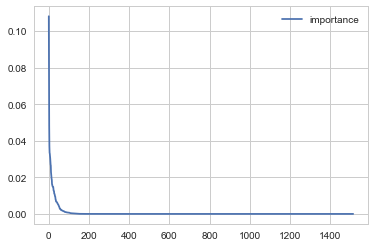

In [31]:
genes_by_importances.sort_values(by='importance', ascending=False).plot(use_index=False)
plt.show()

In [32]:
genes_by_importances.sort_values(by='importance', ascending=False).head(50)

,gene,importance
1258,Sez6,0.108143
247,Cst7,0.068542
253,Ctsd,0.047972
1357,Tbx1,0.037048
161,Ccl21c.1,0.033485
1103,Rpl12,0.032927
594,Gm45212,0.031818
803,Lrrc17,0.030522
430,Gm11033,0.028508
1429,Tyrobp,0.026993


In [33]:
predicted_labels = sgbm.predict(X_test)
predicted_probs = sgbm.predict_proba(X_test)

predicted_df = pd.DataFrame({'predicted': predicted_labels, 
                             'actual': y_test,
                             'KI_prob': predicted_probs[:, 0],
                             'WT_prob': predicted_probs[:, 1]})

In [34]:
predicted_correct = predicted_df[predicted_df['actual'] == predicted_df['predicted']]
predicted_wrong = predicted_df[predicted_df['actual'] != predicted_df['predicted']]

* KI is more often misclassifies as WT, which is expected

In [35]:
predicted_wrong

,KI_prob,WT_prob,actual,predicted
9129,0.430153,0.569847,KI,WT
9002,0.483784,0.516216,KI,WT
301,0.311311,0.688689,KI,WT
9170,0.365698,0.634302,KI,WT
4257,0.519320,0.480680,WT,KI
7850,0.598055,0.401945,WT,KI
68,0.457272,0.542728,KI,WT
9526,0.460020,0.539980,KI,WT
8325,0.555136,0.444864,WT,KI
5251,0.494164,0.505836,KI,WT


In [36]:
len(predicted_wrong) / len(predicted_correct)

0.012745098039215686

---

# LIME explanations

* See: https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html

In [37]:
import lime 
import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

In [45]:
%time
lime_explainer = LimeTabularExplainer(X_train, 
                                      feature_names=GT_features, 
                                      class_names=sgbm.classes_, 
                                      discretize_continuous=False, 
                                      random_state=42)

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 22.6 µs


In [46]:
exp_68 = lime_explainer.explain_instance(X_test.loc[68], sgbm.predict_proba, num_features=20)

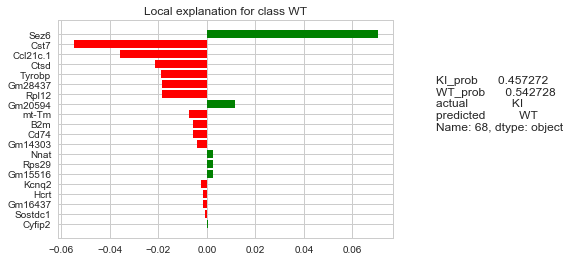

In [47]:
fig = exp_68.as_pyplot_figure()
fig.text(1, 0.5, predicted_wrong.loc[68])

plt.savefig('lime_explanations_wrong_classification.png')
plt.show()

In [48]:
exp_2086 = lime_explainer.explain_instance(X_test.loc[2086], sgbm.predict_proba, num_features=20)
exp_278 = lime_explainer.explain_instance(X_test.loc[278], sgbm.predict_proba, num_features=20)

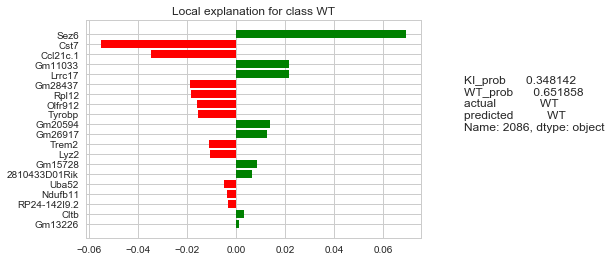

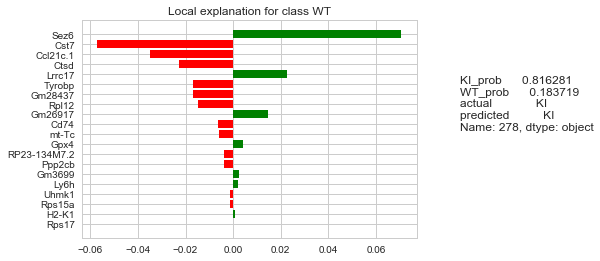

In [49]:
fig = exp_2086.as_pyplot_figure()
fig.text(1, 0.5, predicted_correct.loc[2086])

fig = exp_278.as_pyplot_figure()
fig.text(1, 0.5, predicted_correct.loc[278])

plt.savefig('lime_explanations_correct_classification.png')
plt.show()

---

# Anchor explanations

* See: https://github.com/marcotcr/anchor/blob/master/notebooks/Anchor%20on%20tabular%20data.ipynb

In [50]:
from anchor import utils
from anchor.anchor_tabular import AnchorTabularExplainer

In [51]:
AnchorTabularExplainer?

Init signature: AnchorTabularExplainer(class_names, feature_names, data=None, categorical_names=None, ordinal_features=[])
Docstring:     
Args:
    class_names: list of strings
    feature_names: list of strings
    data: used to build one hot encoder
    categorical_names: map from integer to list of strings, names for each
        value of the categorical features. Every feature that is not in
        this map will be considered as ordinal, and thus discretized.
    ordinal_features: list of integers, features that were
File:           ~/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/anchor/anchor_tabular.py
Type:           type


In [55]:
list(sgbm.classes_)

['KI', 'WT']

In [61]:
anchor_explainer = AnchorTabularExplainer(class_names=sgbm.classes_, feature_names=GT_features)
anchor_explainer.fit(X_train, y_train, X_test, y_test)

TypeError: unhashable type: 'slice'

In [60]:
anch_68 = anchor_explainer.explain_instance(X_test.loc[68], sgbm.predict_proba)

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/anchor/anchor_tabular.py:225: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  true_label = predict_fn(data_row.reshape(1, -1))[0]


AttributeError: 'AnchorTabularExplainer' object has no attribute 'validation'